In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    mean_squared_error,
    r2_score
)

print("✅ All required libraries loaded")


✅ All required libraries loaded


In [2]:
# --- Load dataset ---
df = pd.read_csv(r"D:/Desktop/Telco_Customer_Churn_Clean.csv")

print("✅ Loaded. Shape:", df.shape)
df.head()


✅ Loaded. Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# --- Cleaning / preparation (safe) ---

df = df.copy()
df.columns = df.columns.str.strip()

# Drop ID column if present
df = df.drop(columns=["customerID"], errors="ignore")

# Convert TotalCharges to numeric (invalid -> NaN)
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop missing rows (mostly from TotalCharges)
df = df.dropna().reset_index(drop=True)

# Remove duplicates if any
df = df.drop_duplicates().reset_index(drop=True)

# Fix Churn safely (works for both Yes/No and 0/1)
if "Churn" in df.columns:
    if df["Churn"].dtype == "object":
        df["Churn"] = df["Churn"].astype(str).str.strip().map({"Yes": 1, "No": 0})
    else:
        df["Churn"] = df["Churn"].astype(int)

print("✅ Cleaned. Shape:", df.shape)
print("Churn unique:", df["Churn"].unique())
print("Missing values (should be 0):")
print(df.isnull().sum().sort_values(ascending=False).head(10))

df.head()


✅ Cleaned. Shape: (7010, 20)
Churn unique: [0 1]
Missing values (should be 0):
gender              0
SeniorCitizen       0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
dtype: int64


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


Churn counts:
Churn
0    5153
1    1857
Name: count, dtype: int64

Churn ratio (%):
Churn
0    73.51
1    26.49
Name: proportion, dtype: float64


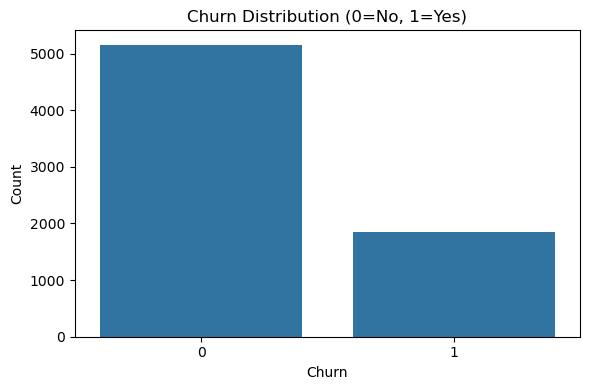

In [4]:
# --- TASK 1: Target Variable Distribution ---

print("Churn counts:")
print(df["Churn"].value_counts())

print("\nChurn ratio (%):")
print((df["Churn"].value_counts(normalize=True)*100).round(2))

plt.figure(figsize=(6,4))
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution (0=No, 1=Yes)")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [5]:
# --- Numeric summary ---
num_cols = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges", "Churn"]

df[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7010.0,0.162767,0.369180,0.00,0.0000,0.000,0.0000,1.00
tenure,7010.0,32.520399,24.520441,1.00,9.0000,29.000,56.0000,72.00
MonthlyCharges,7010.0,64.888666,30.064769,18.25,35.7500,70.400,89.9000,118.75
TotalCharges,7010.0,2290.353388,2266.820832,18.80,408.3125,1403.875,3807.8375,8684.80
Churn,7010.0,0.264907,0.441315,0.00,0.0000,0.000,1.0000,1.00


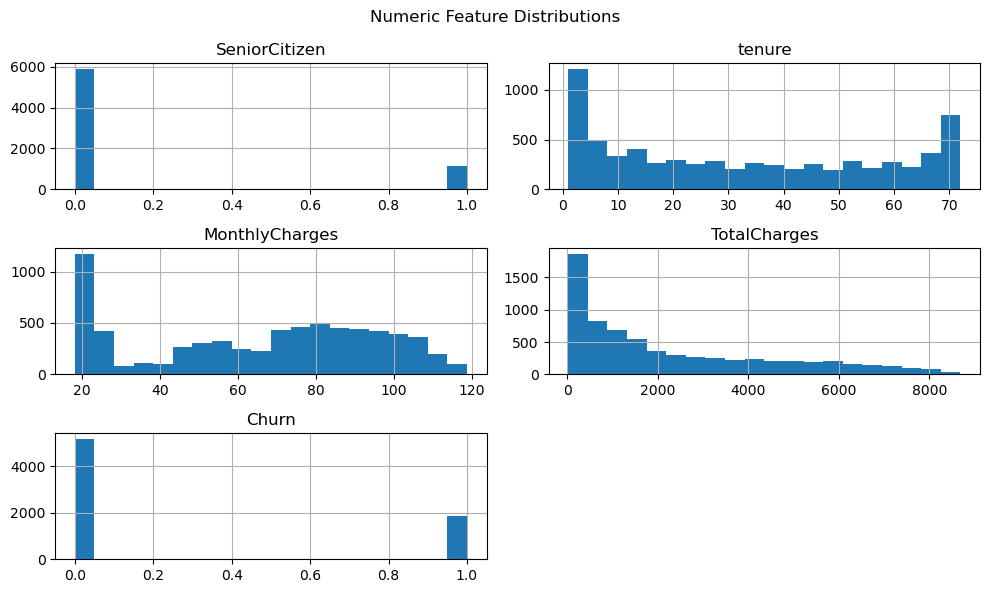

In [6]:
# --- Numeric distributions ---
df[num_cols].hist(figsize=(10,6), bins=20)
plt.suptitle("Numeric Feature Distributions")
plt.tight_layout()
plt.show()


In [7]:
# Churn vs Numeric Boxplot

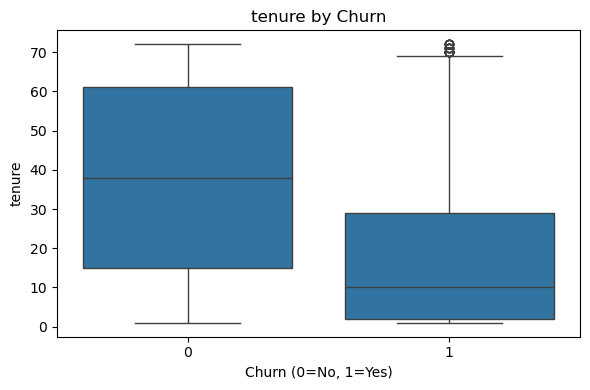

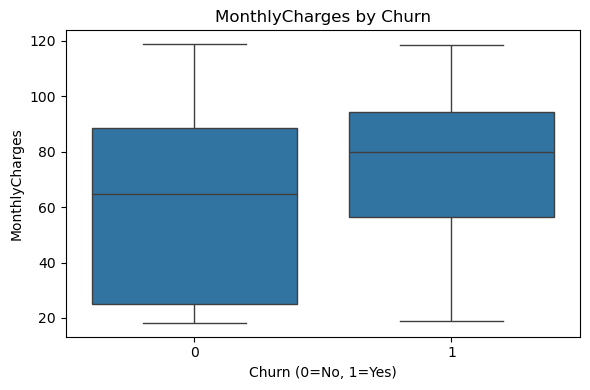

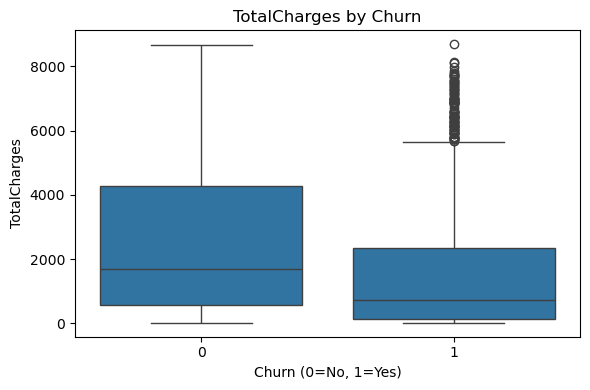

In [8]:
box_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in box_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Churn", y=col, data=df)
    plt.title(f"{col} by Churn")
    plt.xlabel("Churn (0=No, 1=Yes)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


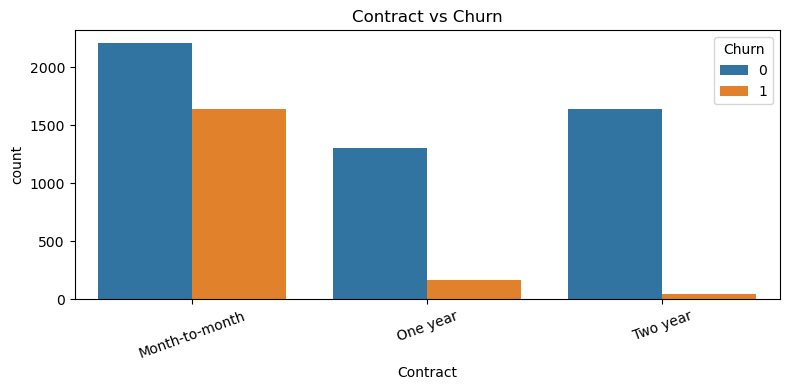

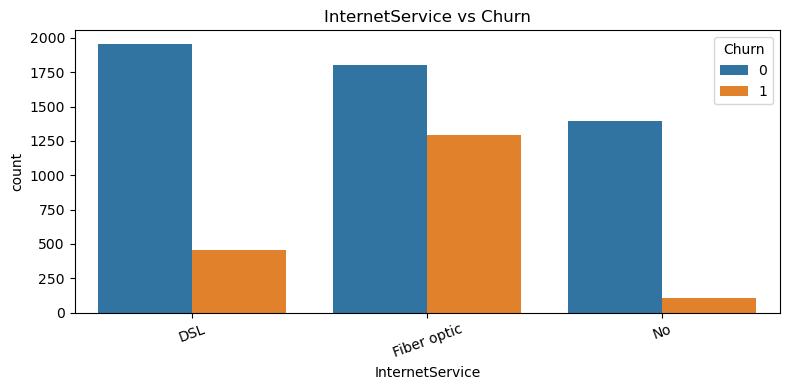

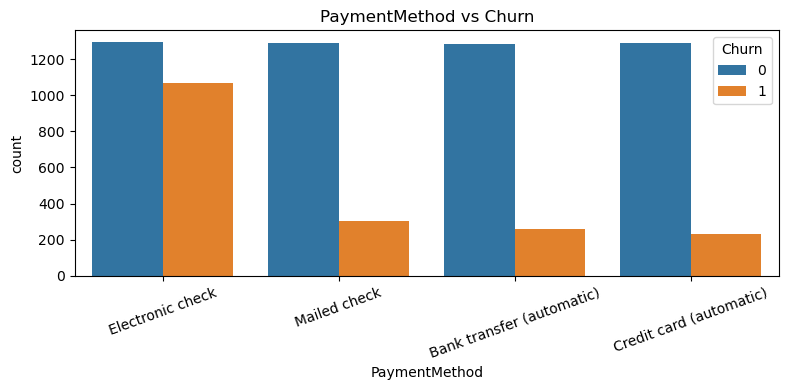

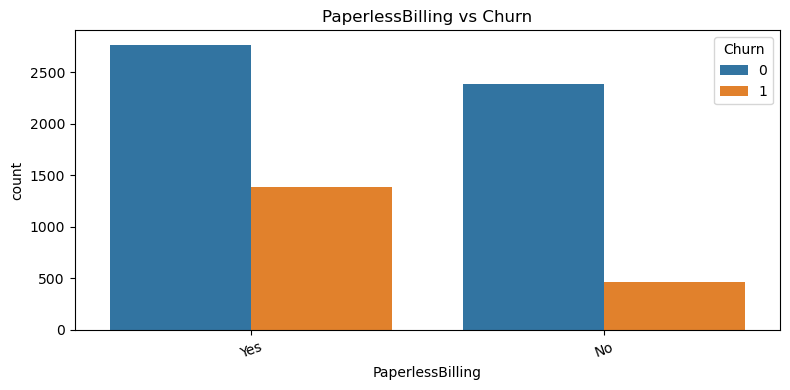

In [9]:
key_cats = ["Contract", "InternetService", "PaymentMethod", "PaperlessBilling"]

for col in key_cats:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue="Churn", data=df)
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()


In [10]:
for col in key_cats:
    churn_rate = (df.groupby(col)["Churn"].mean() * 100).round(2)
    print(f"\nChurn rate by {col} (%):")
    print(churn_rate)



Churn rate by Contract (%):
Contract
Month-to-month    42.64
One year          11.28
Two year           2.85
Name: Churn, dtype: float64

Churn rate by InternetService (%):
InternetService
DSL            18.93
Fiber optic    41.78
No              7.24
Name: Churn, dtype: float64

Churn rate by PaymentMethod (%):
PaymentMethod
Bank transfer (automatic)    16.73
Credit card (automatic)      15.25
Electronic check             45.15
Mailed check                 19.02
Name: Churn, dtype: float64

Churn rate by PaperlessBilling (%):
PaperlessBilling
No     16.34
Yes    33.45
Name: Churn, dtype: float64


In [11]:
# Task 2 

In [12]:
# --- Task 2 imports ---
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

print("✅ Task 2 libraries loaded")


✅ Task 2 libraries loaded


In [13]:
# --- Quick checks ---
print(df.shape)
print(df["Churn"].value_counts())
print(df.dtypes.head())


(7010, 20)
Churn
0    5153
1    1857
Name: count, dtype: int64
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
tenure            int64
dtype: object


In [14]:
# --- Split features and target ---
X = df.drop(columns=["Churn"])
y = df["Churn"].astype(int)

# Identify column types
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()

print("Categorical:", len(cat_cols), cat_cols)
print("Numeric:", len(num_cols), num_cols)


Categorical: 15 ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numeric: 4 ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [15]:
# --- Preprocessing (one-hot + scaling) ---
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# --- Logistic Regression pipeline ---
clf_lr = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

# Train/test split (keep churn ratio similar)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf_lr.fit(X_train, y_train)
y_pred = clf_lr.predict(X_test)

print("✅ Logistic Regression done")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Logistic Regression done
Accuracy: 0.8081

Confusion Matrix:
 [[932  99]
 [170 201]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1031
           1       0.67      0.54      0.60       371

    accuracy                           0.81      1402
   macro avg       0.76      0.72      0.74      1402
weighted avg       0.80      0.81      0.80      1402



In [29]:
# --- Linear Regression pipeline (risk score) ---
reg_lr = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LinearRegression())
])

reg_lr.fit(X_train, y_train)

y_pred_cont = reg_lr.predict(X_test)

# Clip to 0-1 range
y_pred_cont_clip = np.clip(y_pred_cont, 0, 1)

print("MSE:", round(mean_squared_error(y_test, y_pred_cont_clip), 4))
print("R2:", round(r2_score(y_test, y_pred_cont_clip), 4))

pd.DataFrame({
    "Actual": y_test.values[:10],
    "RiskScore": y_pred_cont_clip[:10]
})


MSE: 0.1381
R2: 0.2904


,Actual,RiskScore
0,0,0.354381
1,0,0.015054
2,0,0.234403
3,0,0.361875
4,0,0.296030
5,1,0.442002
6,0,0.162268
7,0,0.125875
8,0,0.282637
9,0,0.273073


In [17]:
X_cluster = X.copy()
X_cluster_prepared = preprocess.fit_transform(X_cluster)

print("Cluster matrix shape:", X_cluster_prepared.shape)


Cluster matrix shape: (7010, 45)


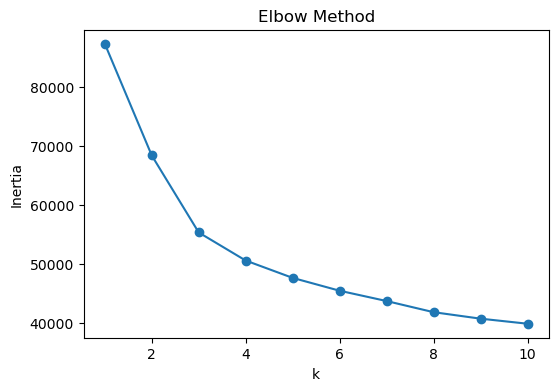

In [27]:
inertias = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_cluster_prepared)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertias, marker="o")
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()


In [19]:
# --- Final KMeans (choose k) ---
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cluster_prepared)

df_clustered = df.copy()
df_clustered["Cluster"] = clusters

print("✅ KMeans done")
print("Cluster counts:\n", df_clustered["Cluster"].value_counts())
df_clustered.head()


✅ KMeans done
Cluster counts:
 Cluster
1    3176
2    2328
0    1506
Name: count, dtype: int64


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Cluster
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1


Churn rate by cluster (%):
 Cluster
0     7.24
1    43.95
2    15.12
Name: Churn, dtype: float64


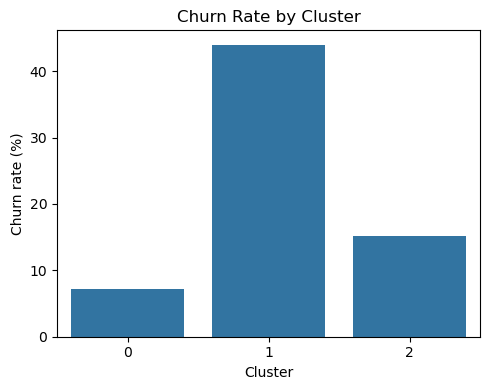

In [20]:
# --- Cluster churn rates ---
cluster_churn = (df_clustered.groupby("Cluster")["Churn"].mean() * 100).round(2)
print("Churn rate by cluster (%):\n", cluster_churn)

plt.figure(figsize=(5,4))
sns.barplot(x=cluster_churn.index, y=cluster_churn.values)
plt.title("Churn Rate by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Churn rate (%)")
plt.tight_layout()
plt.show()


In [21]:
# --- Simple cluster profiling (numeric) ---
profile = df_clustered.groupby("Cluster")[["tenure","MonthlyCharges","TotalCharges","Churn"]].mean().round(2)
print(profile)


         tenure  MonthlyCharges  TotalCharges  Churn
Cluster                                             
0         30.94           21.08        671.22   0.07
1         15.36           67.88       1022.09   0.44
2         56.95           89.15       5068.03   0.15


In [22]:
# --- Simple cluster profiling (categorical modes) ---
cat_profile_cols = ["Contract", "InternetService", "PaymentMethod"]

for col in cat_profile_cols:
    print(f"\nMost common {col} per cluster:")
    print(df_clustered.groupby("Cluster")[col].agg(lambda x: x.value_counts().index[0]))



Most common Contract per cluster:
Cluster
0          Two year
1    Month-to-month
2          Two year
Name: Contract, dtype: object

Most common InternetService per cluster:
Cluster
0             No
1    Fiber optic
2    Fiber optic
Name: InternetService, dtype: object

Most common PaymentMethod per cluster:
Cluster
0                 Mailed check
1             Electronic check
2    Bank transfer (automatic)
Name: PaymentMethod, dtype: object


In [23]:
#Task 3 

In [24]:
# --- Task 3: Imports ---
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve,
    mean_squared_error, r2_score
)

print("✅ Task 3 libs loaded")


✅ Task 3 libs loaded


In [25]:
# --- Task 3: Metrics for Logistic Regression ---
# Assumes: clf_lr, X_test, y_test already exist from Task 2

y_pred = clf_lr.predict(X_test)
y_proba = clf_lr.predict_proba(X_test)[:, 1]

lr_metrics = {
    "Model": "Logistic Regression (Classification)",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision(Churn=1)": precision_score(y_test, y_pred, zero_division=0),
    "Recall(Churn=1)": recall_score(y_test, y_pred, zero_division=0),
    "F1(Churn=1)": f1_score(y_test, y_pred, zero_division=0),
    "ROC-AUC": roc_auc_score(y_test, y_proba)
}

pd.DataFrame([lr_metrics]).round(4)


,Model,Accuracy,Precision(Churn=1),Recall(Churn=1),F1(Churn=1),ROC-AUC
0,Logistic Regression (Classification),0.8081,0.67,0.5418,0.5991,0.8471


In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
print("✅ roc_curve imported")


✅ roc_curve imported


In [30]:
# --- TASK 3: sanity checks (no rebuilding) ---

needed = ["df", "X_test", "y_test", "clf_lr", "reg_lr", "df_clustered"]
missing = [v for v in needed if v not in globals()]

print("Missing objects:", missing)

assert "df" in globals(), "df is missing"
assert "X_test" in globals() and "y_test" in globals(), "X_test / y_test missing (run Task 2 train-test split)"
assert "clf_lr" in globals(), "clf_lr missing (run Task 2 logistic regression pipeline)"
assert "reg_lr" in globals(), "reg_lr missing (run Task 2 linear regression pipeline)"
assert "df_clustered" in globals(), "df_clustered missing (run Task 2 KMeans final clustering)"
print("✅ All Task 3 prerequisites found")


Missing objects: []
✅ All Task 3 prerequisites found


✅ Logistic Regression:
  Accuracy: 0.8081
  Precision: 0.67
  Recall: 0.5418
  F1: 0.5991
  ROC-AUC: 0.8471

✅ Linear Regression (risk score):
  MSE: 0.1381
  R2: 0.2904


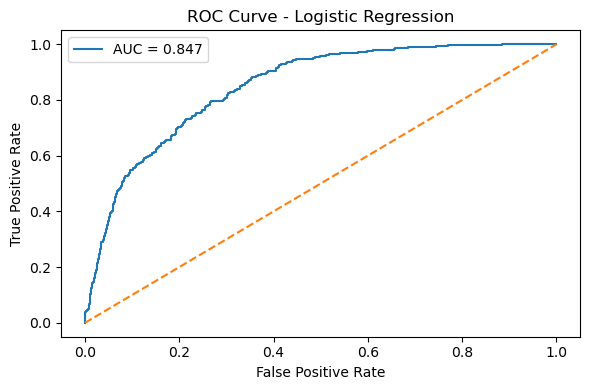

In [31]:
# --- TASK 3: Logistic vs Linear metrics ---

# Logistic (classification)
y_pred = clf_lr.predict(X_test)
y_proba = clf_lr.predict_proba(X_test)[:, 1]

lr_acc = accuracy_score(y_test, y_pred)
lr_prec = precision_score(y_test, y_pred, zero_division=0)
lr_rec = recall_score(y_test, y_pred, zero_division=0)
lr_f1 = f1_score(y_test, y_pred, zero_division=0)
lr_auc = roc_auc_score(y_test, y_proba)

# Linear (risk score)
risk = reg_lr.predict(X_test)
risk = np.clip(risk, 0, 1)

reg_mse = mean_squared_error(y_test, risk)
reg_r2 = r2_score(y_test, risk)

print("✅ Logistic Regression:")
print("  Accuracy:", round(lr_acc, 4))
print("  Precision:", round(lr_prec, 4))
print("  Recall:", round(lr_rec, 4))
print("  F1:", round(lr_f1, 4))
print("  ROC-AUC:", round(lr_auc, 4))

print("\n✅ Linear Regression (risk score):")
print("  MSE:", round(reg_mse, 4))
print("  R2:", round(reg_r2, 4))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {lr_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()


✅ Churn rate by cluster (%):
Cluster
0     7.24
1    43.95
2    15.12
Name: Churn, dtype: float64


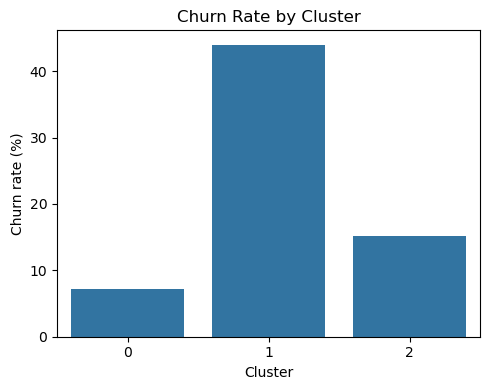

In [32]:
# --- TASK 3: Clustering insight (churn by cluster) ---

cluster_churn = (df_clustered.groupby("Cluster")["Churn"].mean() * 100).round(2)
print("✅ Churn rate by cluster (%):")
print(cluster_churn)

plt.figure(figsize=(5,4))
sns.barplot(x=cluster_churn.index, y=cluster_churn.values)
plt.title("Churn Rate by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Churn rate (%)")
plt.tight_layout()
plt.show()


In [33]:
# --- TASK 3: Comparison table (common points & differences) ---

comparison = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Learning type": "Supervised",
        "Task": "Classification",
        "Output": "Churn class (0/1) + probability",
        "Strength": "Best predictive performance (F1/AUC)",
        "Key numbers": f"Acc={lr_acc:.3f}, F1={lr_f1:.3f}, AUC={lr_auc:.3f}"
    },
    {
        "Model": "Linear Regression",
        "Learning type": "Supervised",
        "Task": "Regression (risk scoring)",
        "Output": "Continuous churn risk score (0-1)",
        "Strength": "Ranking/prioritisation of customers",
        "Key numbers": f"MSE={reg_mse:.3f}, R2={reg_r2:.3f}"
    },
    {
        "Model": "K-Means",
        "Learning type": "Unsupervised",
        "Task": "Clustering",
        "Output": "Customer segments (clusters)",
        "Strength": "Actionable segmentation (cluster-level churn)",
        "Key numbers": "Max churn cluster = " + str(cluster_churn.idxmax()) + f" ({cluster_churn.max():.2f}%)"
    }
])

comparison


,Model,Learning type,Task,Output,Strength,Key numbers
0,Logistic Regression,Supervised,Classification,Churn class (0/1) + probability,Best predictive performance (F1/AUC),"Acc=0.808, F1=0.599, AUC=0.847"
1,Linear Regression,Supervised,Regression (risk scoring),Continuous churn risk score (0-1),Ranking/prioritisation of customers,"MSE=0.138, R2=0.290"
2,K-Means,Unsupervised,Clustering,Customer segments (clusters),Actionable segmentation (cluster-level churn),Max churn cluster = 1 (43.95%)


In [34]:
# --- TASK 3: Code-supported decision hints ---

highest_risk_cluster = cluster_churn.idxmax()
highest_risk_rate = cluster_churn.max()

print("✅ Key takeaways (code-supported):")
print(f"- Logistic Regression: best for prediction (F1={lr_f1:.2f}, AUC={lr_auc:.2f}).")
print(f"- Linear Regression: useful for risk ranking (continuous RiskScore).")
print(f"- K-Means: best for segmentation; highest-risk segment is Cluster {highest_risk_cluster} ({highest_risk_rate:.2f}% churn).")


✅ Key takeaways (code-supported):
- Logistic Regression: best for prediction (F1=0.60, AUC=0.85).
- Linear Regression: useful for risk ranking (continuous RiskScore).
- K-Means: best for segmentation; highest-risk segment is Cluster 1 (43.95% churn).


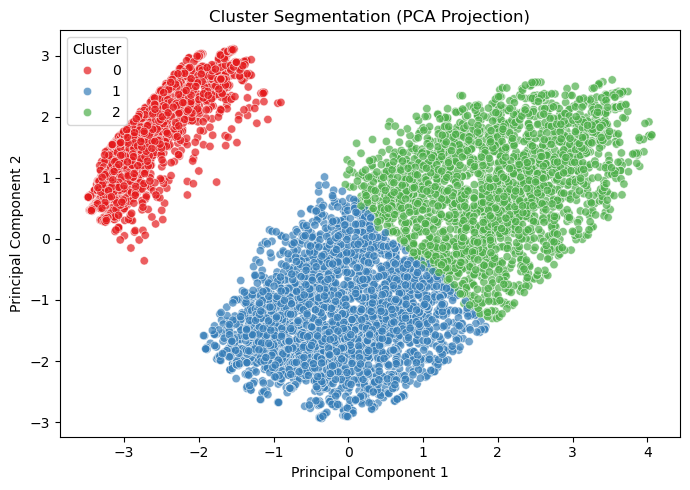

In [36]:
# --- BETTER CLUSTER VISUALIZATION WITH PCA ---

from sklearn.decomposition import PCA

# use the same prepared data used in KMeans
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_prepared)

df_viz = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_viz["Cluster"] = df_clustered["Cluster"]

plt.figure(figsize=(7,5))

sns.scatterplot(
    data=df_viz,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="Set1",
    alpha=0.7
)

plt.title("Cluster Segmentation (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()
